In [3]:
from platform import python_version

print(python_version())

3.10.15


In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, BatchNormalization
from sklearn.model_selection import StratifiedKFold

print(tf.__version__)

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/tensorflow/python/keras/engine/training_arrays_v1.py:37: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.4)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


2.18.0


In [3]:
!pwd

/Users/adamkaribian/Downloads/STATS 415 Project


In [83]:
# Load in training data
X_train = pd.read_csv("UCI_data/train/X_train.txt", delim_whitespace=True, header=None)

y_train = pd.read_csv("UCI_data/train/y_train.txt", header=None)

subject_train = pd.read_csv("UCI_data/train/subject_train.txt", header=None)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"subject_train shape: {subject_train.shape}" ) 

/var/folders/pq/pfv7mvfx2gg9xz7svkt83c6h0000gn/T/ipykernel_1046/2295172403.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv("human+activity+recognition+using+smartphones/UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None)


X_train shape: (7352, 561)
y_train shape: (7352, 1)
subject_train shape: (7352, 1)


In [84]:
# Load in testing data
X_test = pd.read_csv("UCI_data/test/X_test.txt", delim_whitespace=True, header=None)

y_test = pd.read_csv("UCI_data/test/y_test.txt", header=None)

subject_test = pd.read_csv("UCI_data/test/subject_test.txt", header=None)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"subject_test shape: {subject_test.shape}" ) 

/var/folders/pq/pfv7mvfx2gg9xz7svkt83c6h0000gn/T/ipykernel_1046/3596520446.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv("human+activity+recognition+using+smartphones/UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None)


X_test shape: (2947, 561)
y_test shape: (2947, 1)
subject_test shape: (2947, 1)


In [6]:
# Normalize all data together
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# One-hot encode all labels together
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.fit_transform(y_test)

y_train_encoded.shape

(7352, 6)

In [7]:
# Calculate dimensions
n_timesteps = 11
n_features = 51
n_classes = y_train_encoded.shape[1]

In [8]:
# Reshape the data to include a channel dimension if needed
X_train_reshaped = X_train_scaled.reshape(-1, n_timesteps, n_features)
X_test_reshaped = X_test_scaled.reshape(-1, n_timesteps, n_features)

X_train_reshaped.shape

(7352, 11, 51)

In [35]:
# Creating model
def create_model(learning_rate, filters, dropout_rate, batch_size):
    model = Sequential([
        Input(shape=(n_timesteps, n_features)),
        Conv1D(filters=filters,kernel_size=3,padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.002)),
        BatchNormalization(), 
        Dropout(dropout_rate),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=filters, kernel_size=3,padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.002)),
        BatchNormalization(),
        Dropout(dropout_rate),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(6, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Defining grid search
def grid_search(X_train_reshaped, y_train_encoded, param_grid, n_splits=5):
    best_score = 0
    best_params = None
    
    # Convert one-hot encoded y back to class labels (for stratification)
    y_train_classes = np.argmax(y_train_encoded, axis=1)
    
    # Use StratifiedKFold
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for params in ParameterGrid(param_grid):
        print(f"\nTrying params: {params}")
        fold_accuracies = []
        
        # Use y_train_classes for splitting
        for train_index, val_index in skfold.split(X_train_reshaped, y_train_classes):
            X_train_fold, X_val_fold = X_train_reshaped[train_index], X_train_reshaped[val_index]
            y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]
            
            model = create_model(
                learning_rate=params['learning_rate'],
                filters=params['filters'],
                dropout_rate=params['dropout_rate'],
                batch_size=params['batch_size']
            )
             
            # Train with callbacks and validation data
            model.fit(X_train_fold, y_train_fold, 
                     epochs=25, 
                     batch_size=params['batch_size'],
                     validation_data=(X_val_fold, y_val_fold),
                     verbose=0,)


            score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
            fold_accuracies.append(score[1])
            
        avg_accuracy = np.mean(fold_accuracies)
        print(f"Average Validation Accuracy: {avg_accuracy:.4f}")
        
        if avg_accuracy > best_score:
            best_score = avg_accuracy
            best_params = params
            
    return best_params, best_score,

param_grid = {
    'learning_rate': [0.0001, 0.0005],
    'filters': [32, 64],
    'dropout_rate': [0.3, 0.35],
    'batch_size': [64, 128],
}

# Run grid search
best_params, best_score = grid_search(X_train_reshaped, y_train_encoded, param_grid, n_splits=5)
print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_score:.4f}")


Trying params: {'batch_size': 64, 'dropout_rate': 0.3, 'filters': 32, 'learning_rate': 0.0001}
Average Validation Accuracy: 0.8527

Trying params: {'batch_size': 64, 'dropout_rate': 0.3, 'filters': 32, 'learning_rate': 0.0005}
Average Validation Accuracy: 0.9708

Trying params: {'batch_size': 64, 'dropout_rate': 0.3, 'filters': 64, 'learning_rate': 0.0001}
Average Validation Accuracy: 0.9206

Trying params: {'batch_size': 64, 'dropout_rate': 0.3, 'filters': 64, 'learning_rate': 0.0005}
Average Validation Accuracy: 0.9777

Trying params: {'batch_size': 64, 'dropout_rate': 0.35, 'filters': 32, 'learning_rate': 0.0001}
Average Validation Accuracy: 0.8044

Trying params: {'batch_size': 64, 'dropout_rate': 0.35, 'filters': 32, 'learning_rate': 0.0005}
Average Validation Accuracy: 0.9655

Trying params: {'batch_size': 64, 'dropout_rate': 0.35, 'filters': 64, 'learning_rate': 0.0001}
Average Validation Accuracy: 0.8987

Trying params: {'batch_size': 64, 'dropout_rate': 0.35, 'filters': 64, '

Epoch 1/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3123 - loss: 2.1660 - val_accuracy: 0.6832 - val_loss: 1.0203
Epoch 2/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5500 - loss: 1.3341 - val_accuracy: 0.7376 - val_loss: 0.8068
Epoch 3/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6690 - loss: 1.0567 - val_accuracy: 0.7906 - val_loss: 0.6888
Epoch 4/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7281 - loss: 0.8993 - val_accuracy: 0.8681 - val_loss: 0.5740
Epoch 5/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7870 - loss: 0.7537 - val_accuracy: 0.8912 - val_loss: 0.5075
Epoch 6/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8181 - loss: 0.6927 - val_accuracy: 0.9116 - val_loss: 0.4506
Epoch 7/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8545 - loss: 0.6084 - val_accuracy: 0.9273 - val_loss: 0.3972
Epoch 8/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.5535 - val_accuracy: 0.

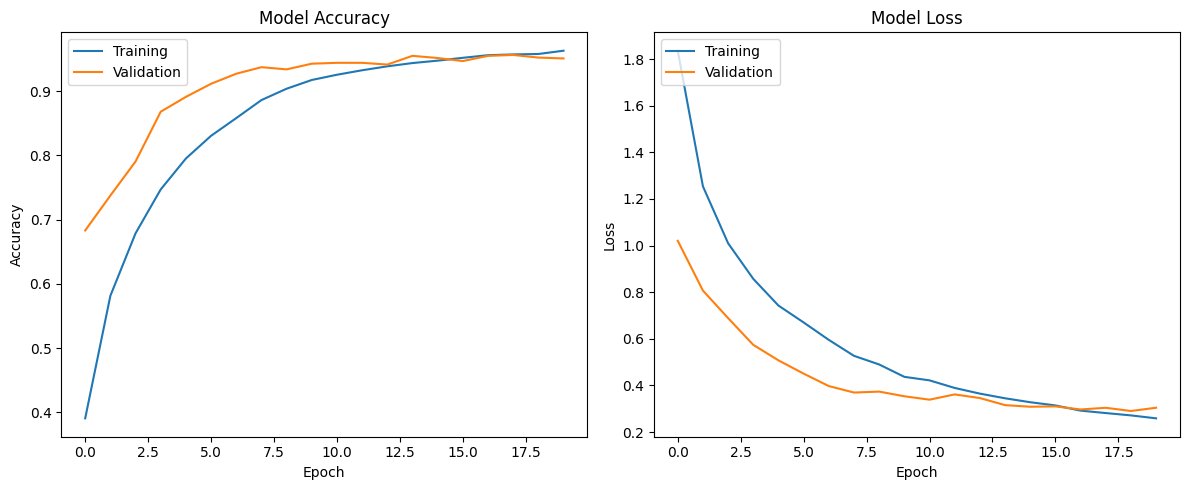

In [123]:
# Define the model creation function with the optimal parameters
def create_optimal_model():
    return create_model(
        learning_rate=best_params['learning_rate'],  
        filters=best_params['filters'],           
        dropout_rate=best_params['dropout_rate'],
        batch_size=best_params['batch_size']
    )

# Train the model with the entire training set and capture the history
model = create_optimal_model()
history = model.fit(X_train_reshaped, y_train_encoded, epochs=20, batch_size=32, verbose=1, validation_split=0.2,
                   callbacks = [tf.keras.callbacks.ModelCheckpoint(
                       'best_model.weights.h5',
                       monitor='val_loss',
                       save_best_only=True,
                       mode='min',
                       save_weights_only=True
                   )])

# Define a function to plot the accuracy and loss
def plot_accuracy_and_loss(history):
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_accuracy_and_loss(history)

In [124]:
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Modifing y_pred and y_test
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)


# Plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix of Human Activities') 
    plt.ylabel('True Activity')
    plt.xlabel('Predicted Activity')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

activity_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [125]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_encoded)
print(f"Test Accuracy: {test_accuracy:.4f}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.9458 - loss: 0.3190
Test Accuracy: 0.9467


In [126]:
import time
import psutil

def measure_inference_performance(model, X_test, n_runs=100):
    """
    Measure inference time and memory usage of the model.
    Args:
        model: Trained TensorFlow model
        X_test: Test data
        n_runs: Number of inference runs to average over
    Returns:
        dict: Performance metrics
    """
    # Warm up the model
    for _ in range(5):
        model.predict(X_test[:1])
    
    # Measure inference time
    latencies = []
    memory_usage = []
    
    for _ in range(n_runs):
        # Single sample inference (real-time scenario)
        start_time = time.time()
        model.predict(X_test[:1])
        latencies.append((time.time() - start_time) * 1000)
        
        # Memory usage
        process = psutil.Process()
        memory_usage.append(process.memory_info().rss / 1024 / 1024)  # Convert to MB
    
    metrics = {
        'avg_inference_time_ms': np.mean(latencies),
        'std_inference_time_ms': np.std(latencies),
        'max_inference_time_ms': np.max(latencies),
        'p95_inference_time_ms': np.percentile(latencies, 95),
        'avg_memory_usage_mb': np.mean(memory_usage),
        'peak_memory_usage_mb': np.max(memory_usage)
    }
    
    return metrics

# Add to model evaluation section:
print("\nMeasuring real-time performance metrics...")
performance_metrics = measure_inference_performance(model, X_test_reshaped)

print("\nReal-time Performance Metrics:")
print(f"Average Inference Time: {performance_metrics['avg_inference_time_ms']:.2f} ms")
print(f"95th Percentile Inference Time: {performance_metrics['p95_inference_time_ms']:.2f} ms")
print(f"Maximum Inference Time: {performance_metrics['max_inference_time_ms']:.2f} ms")
print(f"Average Memory Usage: {performance_metrics['avg_memory_usage_mb']:.2f} MB")
print(f"Peak Memory Usage: {performance_metrics['peak_memory_usage_mb']:.2f} MB")


Measuring real-time performance metrics...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━

In [129]:
import os
import pickle
from datetime import datetime

def create_output_directory(base_dir="outputs"):
    """Create timestamped output directory"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = os.path.join(base_dir, f"run_{timestamp}")
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

def save_model_artifacts(model, history, X_test_reshaped, y_test, output_dir):
    """Save model, weights, and all related artifacts"""
    
    # Save model architecture and weights
    model_path = os.path.join(output_dir, "final_model.h5")
    weights_path = os.path.join(output_dir, "best_model.weights.h5")  # Note this change
    model.save(model_path)
    model.save_weights(weights_path)
    
    # Plot and save training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'), dpi=300, bbox_inches='tight')
    plt.close()

    # Save confusion matrix
    plot_confusion_matrix(y_test_classes, y_pred_classes, activity_labels, 
    os.path.join(output_dir, 'confusion_matrix.png'))

    # Save metrics to inference results file
    with open(os.path.join(output_dir, 'inference_results.txt'), 'w') as f:
        f.write('Real-time Performance Metrics:\n')
        for metric, value in performance_metrics.items():
            f.write(f"{metric}: {value:.2f}\n")
    
    # Create a summary text file
    with open(os.path.join(output_dir, 'summary.txt'), 'w') as f:
        f.write(f"Model Training Summary\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
        f.write(f"\nFinal Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
        f.write(f"\nFinal Training Loss: {history.history['loss'][-1]:.4f}")
        f.write(f"\nFinal Validation Loss: {history.history['val_loss'][-1]:.4f}")

def save_grid_search_results(best_params, best_score, output_dir):
    """Save the best parameters and score from the grid search"""
    summary_path = os.path.join(output_dir, "grid_search_summary.txt")
    with open(summary_path, 'w') as f:
        f.write("Grid Search Results Summary\n\n")
        f.write(f"Best Score: {best_score:.4f}\n\n")
        f.write("Best Parameters:\n")
        for param, value in best_params.items():
            f.write(f"{param}: {value}\n")


In [130]:
# Create output directory
output_dir = create_output_directory()

save_model_artifacts(model, history, X_test_reshaped, y_test, output_dir)

save_grid_search_results(best_params, best_score, output_dir)